## Read the Dataset

In [1]:
import numpy as np

Directory = "D:/S3_project/S Picker/Cooked_Dataset/Dataset100Hz/signal_dataset_20F_100Hz_Scaled_01.npy"
signal_dataset = np.load(Directory)

Directory = "D:/S3_project/S Picker/Cooked_Dataset/Dataset100Hz/label_dataset_20F_100Hz_Scaled_01.npy"
label_dataset = np.load(Directory)

In [2]:
#Check the shape
print(signal_dataset.shape)
print(label_dataset.shape)

(748405, 100, 6)
(748405,)


## Prerocess

Access several Attributes in Trace and Constructing Moving Window

In [3]:
#Access the attribute of period and total Samples
Period = 0.01
train_samples = signal_dataset.shape[0]
df = 1/Period
#First Calculation
train_windows_seconds = 1 #Try training window at 4 seconds
train_windows_samples = int(train_windows_seconds / Period)
moving_windows_seconds = 0.04 #Try overlapping at 0,05second
moving_windows_samples = int(moving_windows_seconds/Period)
print("The period of this data is : ", Period, " Seconds")
print("Try the Training Windows for each ", train_windows_seconds, " Seconds")
print("So, the Training Windows for this data is for each ", train_windows_samples, " Samples")
print("Also, the Moving Windows for this data is for each ", moving_windows_samples, " Samples")
print("It means that there will be ", train_samples, " Training samples from this traces")

The period of this data is :  0.01  Seconds
Try the Training Windows for each  1  Seconds
So, the Training Windows for this data is for each  100  Samples
Also, the Moving Windows for this data is for each  4  Samples
It means that there will be  748405  Training samples from this traces


Check the Label_Dataset

In [4]:
print(label_dataset.shape)
List_Found = (np.where((label_dataset) == 1))[0]
print(List_Found.shape)
List_Found=None

(748405,)
(332733,)


In [5]:
print(signal_dataset.shape)
print(label_dataset.shape)

(748405, 100, 6)
(748405,)


Split the training and test Data

In [6]:
#Using SkLearn or Tensorflow to split the data
from sklearn.model_selection import StratifiedShuffleSplit

#Using stratified split (Keeping the precentage of each class)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(signal_dataset, label_dataset):
    train_signal, test_signal = signal_dataset[train_index], signal_dataset[test_index]
    train_labels, test_labels = label_dataset[train_index], label_dataset[test_index]

Check The Splitting

In [7]:
print(train_signal.shape)
print(test_signal.shape)
print(train_labels.shape)
print(test_labels.shape)

(598724, 100, 6)
(149681, 100, 6)
(598724,)
(149681,)


## Creating Deep Neural Network Model

Make model that can be tuned

In [16]:
#Creating the model for deep learning
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

#We will use a Model from Paper Microseismic 2020 (CNN Explainable)
#Pooling is max pooling with 2x2 window

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense,Flatten

def model_builder(hp):
    # State which hyperparameters to tune
    filter_number_1 = hp.Int('filter_number_1', min_value=8, max_value=33, step=8)
    filter_number_2 = hp.Int('filter_number_2', min_value=8, max_value=33, step=8)
    kernel_size_1 = hp.Int('kernel_size_1', min_value=2, max_value=16, step=2)
    kernel_size_2 = hp.Int('kernel_size_', min_value=2, max_value=8, step=2)
    dense_units = hp.Int('units', min_value=64, max_value=257, step=32)
    
    
    # Build model
    model = Sequential()

    model.add(Conv2D(filter_number_1, (1, kernel_size_1), 
              activation='relu',  padding='same', input_shape=(1, train_windows_samples, 6)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filter_number_2, (1, kernel_size_2), padding = 'same', activation="relu", input_shape=(1, train_windows_samples, 6)))
    model.add(Dropout(0.2))
    #model.add(layers.MaxPooling2D((2, 1)))
    model.add(Flatten())
    model.add(Dense(dense_units, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.2))
    #2 means just two outputs, between noise class or P-Wave Class
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall','AUC'])

    return model

## Compile, Tune, and Training The Model

In [9]:
# Set up checkpoint to save models regularly while training
filepath = "D:/S3_project/S Picker/weights_with_tuner.best.hdf5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#If there is no improvement on val_lost by 10 epochs, it will be stopped!
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20), checkpoint_callback]

orig_train_shape = train_signal.shape
orig_test_shape = test_signal.shape

#reshapes it so we have 3D Tensor
train_signal = train_signal.reshape((orig_train_shape[0], 1, orig_train_shape[1], orig_train_shape[2]))

#reshapes it so we have 3D Tensor
test_signal = test_signal.reshape((orig_test_shape[0], 1, orig_test_shape[1], orig_test_shape[2]))

In [20]:
# Set up tuner
kt_dir = "D:/S3_project/S Picker/kt_dir1.hdf5"
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=15,
                     factor=3,
                     directory='kt_dir',
                     project_name='1_with_tuner')

In [21]:
# Find best hyperparameters
history = tuner.search(train_signal, train_labels,
          batch_size=100,
          callbacks=callback_list, #Learning rate scheduler
          validation_split=0.2, #To split the training more to validation
          epochs=400,
          verbose=1)

Trial 30 Complete [00h 09m 46s]
val_accuracy: 0.9750469923019409

Best val_accuracy So Far: 0.9862457513809204
Total elapsed time: 01h 49m 56s
INFO:tensorflow:Oracle triggered exit


Check best models and other models

In [25]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
filter_number_1 {best_hps.get('filter_number_1')} , filter_number_2 {best_hps.get('filter_number_2')} , kernel_size_1 {best_hps.get('kernel_size_1')},
kernel_size_2 {best_hps.get('kernel_size_2')}, dense {best_hps.get('units')},.
""")
    


filter_number_1 32 , filter_number_2 32 , kernel_size_1 4,
kernel_size_2 6, dense 256,.



In [34]:
all_models=tuner.get_best_hyperparameters()

for model in all_models:
    print(f"""
    filter_number_1 {model.get('filter_number_1')} , filter_number_2 {model.get('filter_number_2')} , kernel_size_1 {model.get('kernel_size_1')},
    kernel_size_2 {model.get('kernel_size_2')}, dense {model.get('units')},.
    """)


    filter_number_1 32 , filter_number_2 32 , kernel_size_1 4,
    kernel_size_2 6, dense 256,.
    


Train with the best model

In [26]:
# Build the model with the optimal hyperparameters and train it on the datas
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_signal, train_labels,
                  batch_size=100,
                  callbacks=callback_list, #Learning rate scheduler
                  validation_split=0.2, #To split the training more to validation
                  epochs=150,
                  verbose=1)

Epoch 1/150
4789/4790 [============================>.] - ETA: 0s - loss: 0.2177 - accuracy: 0.9128 - precision: 0.9141 - recall: 0.8872 - auc: 0.9702
Epoch 1: val_accuracy improved from -inf to 0.93905, saving model to D:/S3_project/S Picker\weights_with_tuner.best.hdf5
4790/4790 [==============================] - 40s 8ms/step - loss: 0.2177 - accuracy: 0.9128 - precision: 0.9141 - recall: 0.8872 - auc: 0.9702 - val_loss: 0.1574 - val_accuracy: 0.9391 - val_precision: 0.9476 - val_recall: 0.9134 - val_auc: 0.9851
Epoch 2/150
4783/4790 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9383 - precision: 0.9346 - recall: 0.9259 - auc: 0.9840
Epoch 2: val_accuracy improved from 0.93905 to 0.95815, saving model to D:/S3_project/S Picker\weights_with_tuner.best.hdf5
4790/4790 [==============================] - 38s 8ms/step - loss: 0.1592 - accuracy: 0.9383 - precision: 0.9346 - recall: 0.9260 - auc: 0.9840 - val_loss: 0.1169 - val_accuracy: 0.9582 - val_precision: 0.955

4788/4790 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9818 - precision: 0.9771 - recall: 0.9821 - auc: 0.9975
Epoch 17: val_accuracy improved from 0.98542 to 0.98605, saving model to D:/S3_project/S Picker\weights_with_tuner.best.hdf5
4790/4790 [==============================] - 38s 8ms/step - loss: 0.0529 - accuracy: 0.9818 - precision: 0.9771 - recall: 0.9821 - auc: 0.9975 - val_loss: 0.0458 - val_accuracy: 0.9861 - val_precision: 0.9747 - val_recall: 0.9944 - val_auc: 0.9976
Epoch 18/150
4789/4790 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9826 - precision: 0.9781 - recall: 0.9828 - auc: 0.9977
Epoch 18: val_accuracy did not improve from 0.98605
4790/4790 [==============================] - 38s 8ms/step - loss: 0.0509 - accuracy: 0.9826 - precision: 0.9781 - recall: 0.9828 - auc: 0.9977 - val_loss: 0.0489 - val_accuracy: 0.9850 - val_precision: 0.9712 - val_recall: 0.9958 - val_auc: 0.9977
Epoch 19/150
4787/4790 [==============

4788/4790 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9868 - precision: 0.9835 - recall: 0.9868 - auc: 0.9985
Epoch 34: val_accuracy did not improve from 0.98798
4790/4790 [==============================] - 38s 8ms/step - loss: 0.0386 - accuracy: 0.9868 - precision: 0.9835 - recall: 0.9868 - auc: 0.9985 - val_loss: 0.0470 - val_accuracy: 0.9859 - val_precision: 0.9721 - val_recall: 0.9968 - val_auc: 0.9977
Epoch 35/150
4787/4790 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9866 - precision: 0.9833 - recall: 0.9866 - auc: 0.9984
Epoch 35: val_accuracy did not improve from 0.98798
4790/4790 [==============================] - 38s 8ms/step - loss: 0.0390 - accuracy: 0.9866 - precision: 0.9833 - recall: 0.9866 - auc: 0.9984 - val_loss: 0.0424 - val_accuracy: 0.9877 - val_precision: 0.9778 - val_recall: 0.9949 - val_auc: 0.9978
Epoch 36/150
4790/4790 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9869 - precision

4790/4790 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9884 - precision: 0.9854 - recall: 0.9885 - auc: 0.9986
Epoch 52: val_accuracy did not improve from 0.98798
4790/4790 [==============================] - 39s 8ms/step - loss: 0.0347 - accuracy: 0.9884 - precision: 0.9854 - recall: 0.9885 - auc: 0.9986 - val_loss: 0.0476 - val_accuracy: 0.9865 - val_precision: 0.9736 - val_recall: 0.9966 - val_auc: 0.9975
Epoch 53/150
4785/4790 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9886 - precision: 0.9857 - recall: 0.9887 - auc: 0.9986
Epoch 53: val_accuracy improved from 0.98798 to 0.98808, saving model to D:/S3_project/S Picker\weights_with_tuner.best.hdf5
4790/4790 [==============================] - 39s 8ms/step - loss: 0.0342 - accuracy: 0.9886 - precision: 0.9857 - recall: 0.9887 - auc: 0.9986 - val_loss: 0.0429 - val_accuracy: 0.9881 - val_precision: 0.9775 - val_recall: 0.9961 - val_auc: 0.9976
Epoch 54/150
4790/4790 [==============

Epoch 70/150
4787/4790 [============================>.] - ETA: 0s - loss: 0.0324 - accuracy: 0.9892 - precision: 0.9865 - recall: 0.9893 - auc: 0.9987
Epoch 70: val_accuracy did not improve from 0.98859
4790/4790 [==============================] - 40s 8ms/step - loss: 0.0324 - accuracy: 0.9892 - precision: 0.9865 - recall: 0.9893 - auc: 0.9987 - val_loss: 0.0486 - val_accuracy: 0.9870 - val_precision: 0.9745 - val_recall: 0.9968 - val_auc: 0.9972
Epoch 71/150
4786/4790 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9891 - precision: 0.9864 - recall: 0.9891 - auc: 0.9987
Epoch 71: val_accuracy did not improve from 0.98859
4790/4790 [==============================] - 39s 8ms/step - loss: 0.0328 - accuracy: 0.9891 - precision: 0.9864 - recall: 0.9891 - auc: 0.9987 - val_loss: 0.0487 - val_accuracy: 0.9873 - val_precision: 0.9751 - val_recall: 0.9968 - val_auc: 0.9973
Epoch 72/150
4786/4790 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.989

Save the model

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1, 100, 32)        800       
                                                                 
 dropout_3 (Dropout)         (None, 1, 100, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 100, 32)        6176      
                                                                 
 dropout_4 (Dropout)         (None, 1, 100, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               819456    
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [28]:
Directory = "D:/S3_project/S Picker/S_Detector1_100Hz_20_with_tuner.h5"
model.save(Directory) 

## Evaluate the model

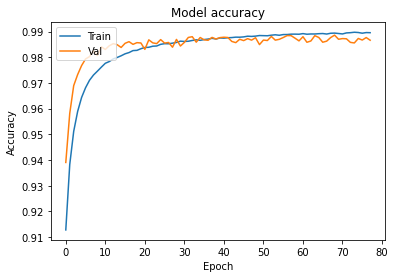

In [29]:
#Visualize the history
#Visualize the models accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

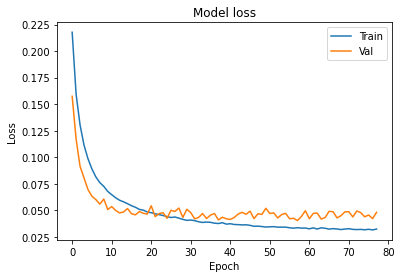

In [30]:
#Visualize the models loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

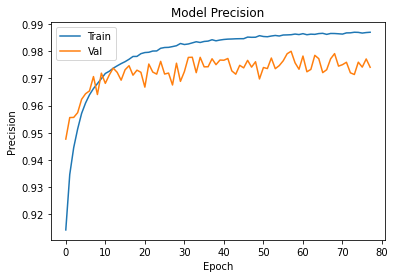

In [31]:
#Visualize the history
#Visualize the models Precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

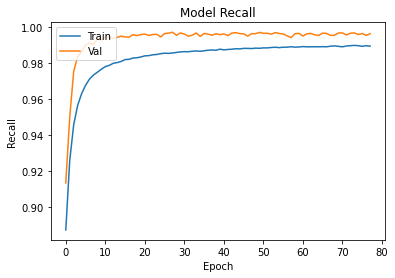

In [35]:
#Visualize the history
#Visualize the models Precision
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [32]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_signal, test_labels, verbose = 2)

print('Test accuracy:', test_acc)

4678/4678 - 19s - loss: 0.0499 - accuracy: 0.9865 - precision: 0.9740 - recall: 0.9964 - auc: 0.9972 - 19s/epoch - 4ms/step
Test accuracy: 0.9865380525588989


In [37]:
import pickle

with open('D:/S3_project/S Picker/history_tuner_1', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)